## Funciones

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [ ]:
# Funciones

def Estandarizar_datos(array):
    tmp = np.array(array[:,-1])
    p = np.mean(array, axis=0)
    d = np.std(array, axis=0)
    for i in range(0, array.shape[0]):
        array[i] = np.true_divide((array[i] - p), d)
    array[:,-1] = tmp[:]
    return array

def Normalizar_datos(datos):
    mean_data = np.sum(datos, axis = 0)/datos.shape[0]
    min_data = datos.min(axis = 0)
    max_data = datos.max(axis = 0)
    datos = (datos - mean_data)/(max_data - min_data)
    return datos

# Funciones k folds
def count_classes(data):
    class1 = []
    class2 = []
    total = 0
    for row in data:
        if row[-1] == True:
            class1.append(row)
        if row[-1] == False:
            class2.append(row)
        total += 1
    return total, class1, class2

def Crear_k_folds(data, k, verbose=False):
    total, class1, class2 = count_classes(data)
    if verbose:
      print('Crear k folds: ', k)
      print('total: ', total, ' clase1: ', len(class1), ' clase2: ', len(class2))
    folds_class1 = np.array_split(class1, k)
    folds_class2 = np.array_split(class2, k)
    results = [0]*k
    for i in range(k):
        results[i] = np.concatenate((folds_class1[i], folds_class2[i]))
        ret = count_classes(results[i])
        if verbose:
          print('fold #', i, ' total elementos: ', ret[0], ' clase1: ', len(ret[1]), ' clase2: ', len(ret[2]))

    return results

def Crear_Conjuntos(folds, i):
    test = folds[i]
    train = np.array([])
    for it in range(len(folds)):
        if it != i:
            # train = np.concatenate((train, folds[it]))
            if len(train) == 0:
                train = folds[it]
            else:
                train = np.concatenate((train, folds[it]))
  
    return test, train

In [ ]:
# funciones 2
def Sigmoidal(z):
    return 1/(1 + np.exp(-(z)))

def pred(X_set, W_set):
    z = np.array(np.dot(X_set, W_set[0]), dtype='float64')
    h_temp = Sigmoidal(z)
    h_temp = np.concatenate((np.ones((len(h_temp), 1)), h_temp), axis=1)
    
    for i in range(1, len(W_set)-1):
        z = np.array(np.dot(h_temp,(W_set[i])), dtype='float64')
        h_temp = Sigmoidal(z)
        h_temp = np.concatenate((np.ones((len(h_temp), 1)), h_temp), axis=1)

    z = np.array(np.dot(h_temp, (W_set[-1])), dtype='float64')
    h_temp = Sigmoidal(z)

    result = np.exp(h_temp)/np.sum(np.exp(h_temp), axis=1, keepdims=True)
    return result

def Calcular_Accuracy(X_set, W_set, y_set):
    y_pred = pred(X_set, W_set)
    y_pred = np.argmax(y_pred, axis=1)
    # print('y pred shape', y_pred.shape, y_pred[0:10])
    y_set_2 = np.argmax(y_set, axis = 1)
    # print('y_set_2 shape', y_set_2.shape, y_pred[0:10])
    count = 0
    for i in range(len(y_pred)):
      if y_pred[i] == y_set_2[i]:
        count += 1
    return ((count) / len(y_pred)) * 100

def Calcular_Funcion_Costo(h_set, y_set):
    return (np.square(y_set - h_set).mean())*(0.5)

def d_cost(y_calculated, y_set):
    return (y_set - y_calculated)

def dS(d_data):
    return d_data * (1.0 - d_data)

def Forward(X_set, W_layers_set, num_layers):
    #Init forward with empty h set
    h_list = []
    #First layer
    z = np.array(np.dot(X_set, W_layers_set[0]), dtype='float64')
    h_temp = Sigmoidal(z)
    h_temp = np.concatenate((np.ones((len(h_temp), 1)), h_temp), axis=1)
    h_list.append(h_temp)
    
    #Hidden layers (without first layer)
    for i in range(1, num_layers):
        #Principal difference is Z
        z = np.array(np.dot(h_temp,(W_layers_set[i])), dtype='float64')
        h_temp = Sigmoidal(z)
        h_temp = np.concatenate((np.ones((len(h_temp), 1)), h_temp), axis=1)
        h_list.append(h_temp)

    #Last layer
    z = np.array(np.dot(h_temp, (W_layers_set[-1])), dtype='float64')
    h_temp = Sigmoidal(z)
    h_list.append(h_temp)

    return h_list

def Backward(X_set, h, l, y_output, learning_rate):
    it_back = len(h)-1
    w_backward = []

    dLoss = d_cost(y_output, h[iterator_back])
    dh2 = dS(h[iterator_back])
    dz2 = h[iterator_back-1]

    save = dLoss * dh2
    dl = dz2.T.dot(save) 

    w_backward.append(dl)

    #Retro propagacion
    i=0
    while it_back >= 1:
        dLoss = np.dot(save,(l[it_back]).T)
        dLoss = dLoss[:,1:]
        it_back = it_back-1
        dh2 = dS(h[it_back])
        dh2 = dh2[:,1:]
        
        # si alcanza la primera capa
        if(it_back-1 < 0):
            dz2 = X_set
        else:
            dz2 = h[it_back-1]

        save = dLoss*dh2
        dl = dz2.T.dot(save) 
        w_backward.append(dl)

        i+=1
    
    #Actualizar pesos
    j = len(l)-1
    for i in range(len(l)):
        l[i] = l[i] - learning_rate * w_backward[j]
        j = j-1
    return l

def iniciar_pesos_random(X_set, num_layers, array_num_neurons, num_neurons_output_layer):
    w_set = []
    w_temp = np.random.rand(X_set.shape[1], array_num_neurons[0])
    w_set.append(w_temp)
    
    for i in range(num_layers - 1):
        w_temp = np.random.rand(array_num_neurons[i] + 1, array_num_neurons[i+1])
        w_set.append(w_temp)

    w_temp = np.random.rand(array_num_neurons[-1] + 1, num_neurons_output_layer)
    w_set.append(w_temp)
    return w_set

def Gradiente_Descendiente(X_set, y_set, num_neurons, num_iterations, learning_rate):   
    num_neurons_output_layer = y_set.shape[1]
    num_layers = len(num_neurons)
    
    #Para guardar los pesos
    gradient_costs = np.zeros((num_iterations, 1))
    
    #Init weights
    W_set = iniciar_pesos_random(X_set, num_layers, num_neurons, num_neurons_output_layer)
     
    for i in range (num_iterations):
        #Forward
        h_forward = []
        h_forward = Forward(X_set, W_set, num_layers)
        gradient_costs[i] = Calcular_Funcion_Costo(h_forward[-1], y_set)
        #Backward
        w_backward = Backward(X_set, h_forward, W_set, y_set, learning_rate)
    
    return gradient_costs, w_backward

## MLP

In [ ]:
# Procesar datos
pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", 5)
file1 = pd.read_csv('https://raw.githubusercontent.com/agublazer/topicosia/master/practica2/data/titanic_test.csv')
file2 = pd.read_csv('https://raw.githubusercontent.com/agublazer/topicosia/master/practica2/data/titanic_train.csv')
ids = pd.read_csv('https://raw.githubusercontent.com/agublazer/topicosia/master/practica2/data/gender_submission.csv')

# Unir conjunto de test con atributo Survived
file1 = pd.concat([file1, ids], axis=1, join="inner")

# Quitar atributos innecesarios y unir ambos archivos
file1 = file1[['Sex', 'Age', 'Fare', 'Embarked', 'Survived']]
file2 = file2[['Sex', 'Age', 'Fare', 'Embarked', 'Survived']]
full_df = pd.concat([file1, file2])

mapdict = {'Embarked': {'Q': 0, 'S': 1, 'C': 2}, 'Sex': {'male': 1, 'female': 0}}
full_df = full_df.replace(mapdict)

full_df = full_df.dropna()
full_df = full_df.values
print(full_df.shape)

(1043, 5)


In [ ]:
def run_k_folds(data_entrada, k, neurons, testing_set='test'): 
  data_entrada = Estandarizar_datos(data_entrada)
  folds = Crear_k_folds(data_entrada, 3)
  iterations = [500, 1000, 1500, 2000, 2500, 3000, 3500]
  learning_rate = [0.001, 0.01, 0.1]

  param_shape = (len(learning_rate),len(iterations))
  param_table = np.zeros(param_shape)
  
  for i in range(k):
    test_set, train_set = Crear_Conjuntos(folds, i)

    # train set
    X_train = np.array(train_set[:, 0:-1])
    # X_train = np.insert(X_train, 0, 1, axis=1)
    Y_train = np.array(train_set[:, -1])
    Y_conv_train  = np.zeros((Y_train.shape[0], 2), dtype='float64')
    Y_conv_train[:,0] = Y_train[:] == True
    Y_conv_train[:,1] = Y_train[:] == False

    # test set
    X_test = np.array(test_set[:, 0:-1])
    # X_test = np.insert(X_test, 0, 1, axis=1)
    Y_test = np.array(test_set[:, -1])
    Y_conv_test  = np.zeros((Y_test.shape[0], 2), dtype='float64')
    Y_conv_test[:,0] = Y_test[:] == True
    Y_conv_test[:,1] = Y_test[:] == False

    # gradient
    for lr in range(len(learning_rate)):
        for it in range(len(iterations)):
          costs, weights = Gradiente_Descendiente(X_train, Y_conv_train, neurons, iterations[it], learning_rate[lr])
          accuracy = 0.0
          if testing_set is 'train':
            accuracy = Calcular_Accuracy(X_train, weights, Y_conv_train)
          if testing_set is 'test':
            accuracy = Calcular_Accuracy(X_test, weights, Y_conv_test)
          param_table[lr, it] += accuracy
        # print('learning rate done: ', learning_rate[lr])
    # plt.plot(titanic_gradient_costs)

  param_table = param_table/k
  final_df = pd.DataFrame(data=param_table, index = learning_rate, columns=iterations)

  print('=========== Resultados ==========')
  display(final_df)

  id_1, id_2 = np.where(param_table == param_table.max())  # hallar indices de elemento minimo
  if len(id_1) > 1:  # si hay mas de un minimo imprimimos el primero
    id_1 = id_1[0]
    id_2 = id_2[0]
  print('================ Parámetros ==================')
  print ('Max accuracy: ', param_table.max())
  print ('Learning rate: ', learning_rate[int(id_1)])
  print ('Iterations: ', iterations[int(id_2)])
  return param_table, learning_rate[int(id_1)], iterations[int(id_2)]

  

In [12]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
layers_list = [[5], [5, 6], [4, 2, 5]]
for layers in layers_list:
  print('################ CAPA : ', layers)
  run_k_folds(full_df, 3, layers, 'test')

################ CAPA :  [5]
=========== Resultados ==========


,500,1000,1500,2000,2500,3000,3500
0.001,84.346383,83.295762,82.817657,84.059299,83.868277,84.155361,84.155361
0.010,84.154810,83.964889,84.060400,83.391823,83.773867,83.773867,83.582845
0.100,83.391823,82.722696,83.775519,83.392924,82.051917,83.679457,80.907987


================ Parámetros ==================
Max accuracy:  84.34638283114374
Learning rate:  0.001
Iterations:  500
################ CAPA :  [5, 6]
=========== Resultados ==========


,500,1000,1500,2000,2500,3000,3500
0.001,70.201399,84.250872,83.677255,84.250872,84.059299,83.104190,84.059299
0.010,83.868277,83.869378,83.296313,83.105291,84.156462,83.296313,82.723247
0.100,71.834444,83.394025,78.296161,74.792532,76.513381,83.200802,82.723247


================ Parámetros ==================
Max accuracy:  84.25087184738061
Learning rate:  0.001
Iterations:  1000
################ CAPA :  [4, 2, 5]
=========== Resultados ==========


,500,1000,1500,2000,2500,3000,3500
0.001,60.211005,60.211005,65.974694,71.834444,71.834444,84.346383,83.486233
0.010,84.728427,83.200251,82.723247,83.868828,83.486784,83.105291,83.199150
0.100,81.672075,78.200650,79.762957,81.098459,83.391273,81.767036,82.628837


================ Parámetros ==================
Max accuracy:  84.72842676619628
Learning rate:  0.01
Iterations:  500


In [ ]:
from sklearn.datasets import load_iris

iris = load_iris()

# Preparar dataset
iris_data = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])
# print(data1)
print(iris_data.values.shape)
layers_list = [[6], [6, 6], [6, 6, 6]]
for layers in layers_list:
  print('################ CAPA : ', layers)
  run_k_folds(iris_data.values, 3, layers, 'test')

(150, 5)
################ CAPA :  [6]
=========== Resultados ==========


,500,1000,1500,2000,2500,3000,3500
0.001,100.0,100.0,100.0,100.0,100.0,100.0,100.0
0.010,100.0,100.0,100.0,100.0,100.0,100.0,100.0
0.100,100.0,100.0,100.0,100.0,100.0,100.0,100.0


================ Parámetros ==================
Max accuracy:  100.0
Learning rate:  0.001
Iterations:  500
################ CAPA :  [6, 6]
=========== Resultados ==========


,500,1000,1500,2000,2500,3000,3500
0.001,52.083333,64.338235,90.196078,97.058824,100.0,100.0,100.0
0.010,100.000000,100.000000,100.000000,100.000000,100.0,100.0,100.0
0.100,100.000000,100.000000,100.000000,100.000000,100.0,100.0,100.0


================ Parámetros ==================
Max accuracy:  100.0
Learning rate:  0.001
Iterations:  2500
################ CAPA :  [6, 6, 6]
=========== Resultados ==========


,500,1000,1500,2000,2500,3000,3500
0.001,50.000000,50.000000,50.0,51.041667,50.0,51.041667,50.0
0.010,62.377451,81.372549,100.0,100.000000,100.0,100.000000,100.0
0.100,100.000000,100.000000,100.0,100.000000,100.0,100.000000,100.0


================ Parámetros ==================
Max accuracy:  100.0
Learning rate:  0.01
Iterations:  1500


### SVM

In [ ]:
# full_df = full_df.values
from sklearn import svm
import matplotlib.pyplot as plt

def run_k_folds_clf(data_entrada, k, clf):
  folds = Crear_k_folds(data_entrada, k)
  accuracy = 0
  for i in range(k):
    test_set, train_set = Crear_Conjuntos(folds, i)

    # train set
    X_train = np.array(train_set[:, 0:-1])
    Y_train = np.array(train_set[:, -1])

    # test set
    X_test = np.array(test_set[:, 0:-1])
    Y_test = np.array(test_set[:, -1])
    clf.fit(X_train, Y_train)
    predictions = clf.predict(X_test)
    total = 0
    success = 0
    for i in range(len(predictions)):
      total += 1
      if (predictions[i] == Y_test[i]):
        success += 1
  
    accuracy +=success/total * 100 
  
  return clf, accuracy/k

kernels = ['linear', 'rbf', 'poly']
"""
for kernel in kernels:
  # titanic
  svc1 = svm.SVC(kernel=kernel)
  svc1, acc = run_k_folds_clf(full_df, 3, svc1)
  print('titanic', kernel, acc)
  # iris
  svc2 = svm.SVC(kernel=kernel)
  # svc2, acc = run_k_folds_clf(iris_data.values, 3, svc2)
  print('iris', kernel, acc)

print(full_df)
print(iris.values())
"""
# Lineal
svc = svm.SVC(kernel='linear')  # Titanic
svc, acc = run_k_folds_clf(full_df, 3, svc)
print('titanic lineal:', acc) 

svc = svm.SVC(kernel='linear')  # iris
svc, acc = run_k_folds_clf(iris_data.values, 3, svc)
print('iris lineal:', acc)


titanic lineal: 84.91944873372253
iris lineal: 100.0


In [ ]:
# Gaussiano - Gamma
gammas = [0.1, 1, 10, 100]
gammas_titanic = []
gammas_iris = []

for gamma in gammas:
    # Titanic
    svc = svm.SVC(kernel='rbf', gamma=gamma)
    svc, acc = run_k_folds_clf(full_df, 3, svc)
    gammas_titanic.append(acc)
    # iris
    svc = svm.SVC(kernel='rbf', gamma=gamma)
    svc, acc = run_k_folds_clf(iris_data.values, 3, svc)
    gammas_iris.append(acc)

print('Gaussiano - gamma')
data_final_pandas = pd.DataFrame(data=[gammas_titanic, gammas_iris], columns=gammas, index=['titanic', 'iris'])
display(data_final_pandas)
max_titanic_gamma = gammas_titanic.index(max(gammas_titanic))
print('max titanic gamma', max(gammas_titanic), gammas[max_titanic_gamma])
max_iris_gamma = gammas_iris.index(max(gammas_iris))
print('max iris gamma', max(gammas_iris), gammas[max_iris_gamma], '\n')

# Gaussiano - C
c_list = [0.1, 1, 10, 1000]
c_titanic = []
c_iris = []

for c in c_list:
    # Titanic
    svc = svm.SVC(kernel='rbf', C=c)
    svc, acc = run_k_folds_clf(full_df, 3, svc)
    c_titanic.append(acc)
    # iris
    svc = svm.SVC(kernel='rbf', C=c)
    svc, acc = run_k_folds_clf(iris_data.values, 3, svc)
    c_iris.append(acc)

print('Gaussiano - C')
data_final_pandas = pd.DataFrame(data=[c_titanic, c_iris], columns=c_list, index=['titanic', 'iris'])
display(data_final_pandas)
max_titanic_c = c_titanic.index(max(c_titanic))
print('max titanic c', max(c_titanic), c_list[max_titanic_c])
max_iris_c = c_iris.index(max(c_iris))
print('max iris c', max(c_iris), c_list[max_iris_c], '\n')

Gaussiano - gamma


,0.1,1.0,10.0,100.0
titanic,64.340548,63.759224,61.650276,61.745787
iris,100.000000,98.958333,95.036765,74.019608


max titanic gamma 64.34054757795705 0.1
max iris gamma 100.0 0.1 

Gaussiano - C


,0.1,1.0,10.0,1000.0
titanic,65.105186,65.008023,65.872577,83.869929
iris,100.000000,100.000000,100.000000,100.000000


max titanic c 83.86992890349536 1000
max iris c 100.0 0.1 



In [ ]:
# Polinomial - degree
degrees = [0, 1, 2, 3, 4, 5, 6]
degrees_titanic = []
degrees_iris = []

for degree in degrees:
    # Titanic
    svc = svm.SVC(kernel='poly', degree=degree)
    svc, acc = run_k_folds_clf(full_df, 3, svc)
    degrees_titanic.append(acc)
    # iris
    svc = svm.SVC(kernel='poly', degree=degree)
    svc, acc = run_k_folds_clf(iris_data.values, 3, svc)
    degrees_iris.append(acc)

print('Polinomial - degree')
data_final_pandas = pd.DataFrame(data=[degrees_titanic, degrees_iris], columns=degrees, index=['titanic', 'iris'])
display(data_final_pandas)
max_titanic_degree = degrees_titanic.index(max(degrees_titanic))
print('max titanic degree', max(degrees_titanic), degrees[max_titanic_degree])
max_iris_degree = degrees_iris.index(max(degrees_iris))
print('max iris degree', max(degrees_iris), degrees[max_iris_degree], '\n')


Polinomial - degree


,0,1,2,3,4,5,6
titanic,60.211005,63.378832,62.704199,62.318853,63.183406,63.759224,64.142369
iris,50.000000,100.000000,100.000000,100.000000,100.000000,100.000000,99.019608


max titanic degree 64.14236916784334 6
max iris degree 100.0 1 



No handles with labels found to put in legend.


Plot Iris


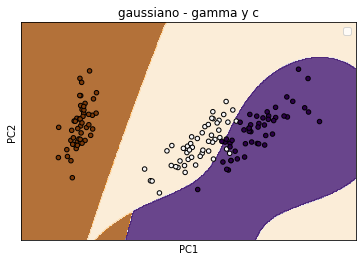

No handles with labels found to put in legend.


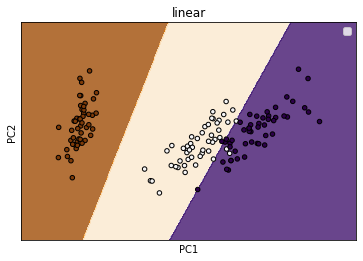

No handles with labels found to put in legend.


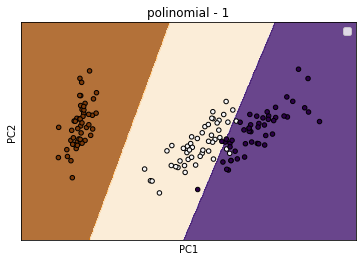

No handles with labels found to put in legend.


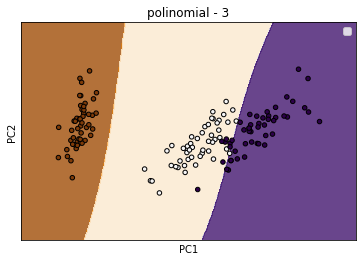

In [ ]:
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.decomposition import PCA

iris = datasets.load_iris()

def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

def plot_model(data_X, data_Y, clf, p_title):
  pca = PCA(n_components=2)
  Xreduced = pca.fit_transform(data_X)
  clf = model.fit(Xreduced, data_Y)
  fig, ax = plt.subplots()
  # Set-up grid for plotting.
  X0, X1 = Xreduced[:, 0], Xreduced[:, 1]
  xx, yy = make_meshgrid(X0, X1)
  plot_contours(ax, clf, xx, yy, cmap=plt.cm.PuOr, alpha=0.8)
  ax.scatter(X0, X1, c=data_Y, cmap=plt.cm.PuOr, s=20, edgecolors='k')
  ax.set_ylabel('PC2')
  ax.set_xlabel('PC1')
  ax.set_xticks(())
  ax.set_yticks(())
  ax.set_title(p_title)
  ax.legend()
  plt.show()

print('Plot Iris')

model = svm.SVC(kernel='rbf', gamma=0.1, C=1000)
plot_model(iris.data, iris.target, model, 'gaussiano - gamma y c')
model = svm.SVC(kernel='linear')
plot_model(iris.data, iris.target, model, 'linear')
model = svm.SVC(kernel='poly', degree=1)
plot_model(iris.data, iris.target, model, 'polinomial - 1')
model = svm.SVC(kernel='poly', degree=3)
plot_model(iris.data, iris.target, model, 'polinomial - 3')



Plot Titanic


No handles with labels found to put in legend.


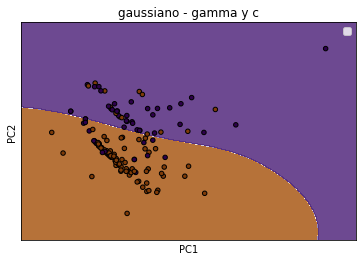

No handles with labels found to put in legend.


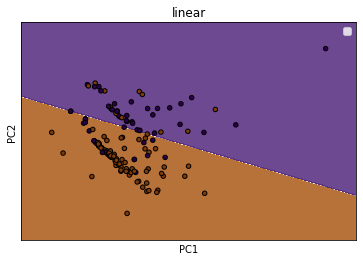

No handles with labels found to put in legend.


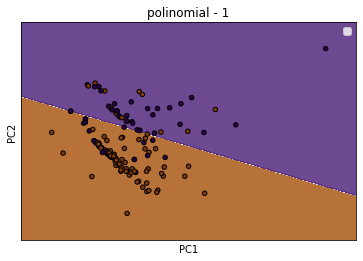

No handles with labels found to put in legend.


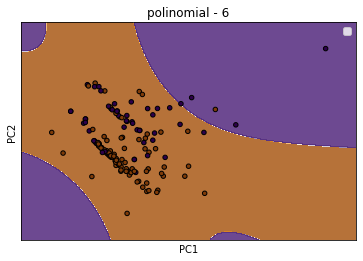

In [ ]:
print('Plot Titanic')
full_df_copy = full_df.copy()
data_entrada = Estandarizar_datos(full_df_copy)
x_df_copy = data_entrada[400:550, 0:-1]
y_df_copy = data_entrada[400:550, -1]
model = svm.SVC(kernel='rbf', gamma=0.1, C=1.0)
plot_model(x_df_copy, y_df_copy, model, 'gaussiano - gamma y c')
model = svm.SVC(kernel='linear')
plot_model(x_df_copy, y_df_copy, model, 'linear')
model = svm.SVC(kernel='poly', degree=1)
plot_model(x_df_copy, y_df_copy, model, 'polinomial - 1')
model = svm.SVC(kernel='poly', degree=4)
plot_model(x_df_copy, y_df_copy, model, 'polinomial - 6')
